<a href="https://colab.research.google.com/github/dizzySummer/NLP-TensorFlow2.0/blob/master/Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a test to combine a custom tokenization method (own corpus) with the Roberta model.  The corpus was chosen from twitter text.   No text preprocessing needed. TPU is required.

In [1]:
!import libraries and data

/bin/bash: import: command not found


In [0]:
#!pip install transformers

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import os
import time
import sys

import re
import nltk 
nltk.download('punkt')
from nltk.corpus import stopwords
import tensorflow as tf
tf.keras.backend.clear_session()

import torch
import transformers
from sklearn.model_selection import StratifiedKFold
from transformers import *
from transformers import RobertaConfig, TFRobertaPreTrainedModel
from transformers.modeling_tf_roberta import TFRobertaMainLayer
from transformers.modeling_tf_utils import get_initializer

import itertools
import collections
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#turn on TPU https://heartbeat.fritz.ai/step-by-step-use-of-google-colab-free-tpu-75f8629492b3
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: 10.103.80.154:8470


INFO:tensorflow:Initializing the TPU system: 10.103.80.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [0]:
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")
submission=pd.read_csv("/content/drive/My Drive/sample_submission.csv")

In [33]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [34]:
train.head()

,id,keyword,location,text,target,Tokened_Text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[2, 690, 12134, 257, 143, 2635, 157, 251, 6, 1..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[2, 987, 337, 672, 1312, 5587, 473, 361, 89, 9..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[2, 319, 4995, 4568, 153, 10, 5241, 149, 2204,..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[2, 1360, 15, 7036, 438, 14629, 6, 4237, 1261,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[2, 299, 636, 2596, 251, 1439, 272, 1479, 102,..."


In [7]:
# check class distribution in train dataset
from scipy import stats
train.groupby(['target']).size()

target
0    4342
1    3271
dtype: int64

In [0]:
#Build corpus

In [0]:
all_texts = []
for line in list(train['text']):
    texts = line.split()
    for text in texts:
        all_texts.append(text)

In [0]:
toBeCleanedNew='[%s]' % ' '.join(map(str, all_texts))#remove all the quation marks and commas. 
#print(toBeCleanedNew)

In [0]:
rawCorpus='[%s]' % ' '.join(map(str, all_texts))#remove all the quation marks and commas. 
#print(rawCorpus)
with open("/content/drive/My Drive/rawCorpus.txt", "w") as output:
    output.write(str(rawCorpus))

In [0]:
#install transformer tokenizers to train corpus

Here are the pre-process requirement for the 5 model types recommended by  huggingface. 

BERT: [CLS] + tokens + [SEP] + padding

DistilBERT: [CLS] + tokens + [SEP] + padding

RoBERTa: [CLS] + prefix_space + tokens + [SEP] + padding

XLM: [CLS] + tokens + [SEP] + padding

XLNet: padding + tokens + [SEP] + [CLS]

In [13]:
!pip install tokenizers==0.4.2

In [0]:
#!pip install tokenizers #hugging face tokenizer
#Huggingface recommends to use ByteLevel tokenizer for Roberta model. But the result was bad. Take BertWordPiece now
from tokenizers import (ByteLevelBPETokenizer,
                            CharBPETokenizer,
                            SentencePieceBPETokenizer,
                            BertWordPieceTokenizer)
tokenizer = BertWordPieceTokenizer()

path="/content/drive/My Drive/rawCorpus.txt"
#set vocab_size to 15000 as the len(train_set)was something like 12500 
tokenizer.train(files=path, vocab_size=15_000, min_frequency=2)
#tokenizer.train(files=path, vocab_size=15_000, min_frequency=2,special_tokens=[
   # "<s>",
    #"<pad>",
    #"</s>",
    #"<unk>",
    #"<mask>"
#])

In [15]:
tokenizer.save(".","/content/drive/My Drive/newBert")

['/content/drive/My Drive/newBert-vocab.txt']

In [0]:
tokenizer = BertWordPieceTokenizer(
    '/content/drive/My Drive/newBert-vocab.txt',
     lowercase=True, 

)

In [17]:
output = tokenizer.encode("Hello, y'all! 🙂 How are you  ?")
print(output.tokens)
print(output.ids)

['[CLS]', 'hello', ',', 'y', "'", 'all', '!', '[UNK]', 'how', 'are', 'you', '?', '[SEP]']
[2, 3996, 15, 65, 10, 319, 5, 1, 439, 257, 172, 33, 3]


In [0]:
#apply tokens to all texts

In [0]:
def bert_token(texts,max_len=512): 
    all_input_ids=[]
    all_mask_ids=[]
    all_seg_ids=[]
    for token in texts: 
    
        input_ids=tokenizer.encode(token).ids
        mask_ids = [1] * len(input_ids)
        seg_ids = [0] * len(input_ids)
        padding = [0] * (max_len - len(input_ids))
        input_ids += padding
        mask_ids += padding
        seg_ids += padding
        all_input_ids.append(input_ids)
        all_mask_ids.append(mask_ids)
        all_seg_ids.append(seg_ids)

    
    return np.array(all_input_ids), np.array(all_mask_ids), np.array(all_seg_ids)


In [0]:
train_input=bert_token(train['text'],max_len=100)
test_input=bert_token(test['text'],max_len=100)

In [21]:
print(train_input)

(array([[    2,   690, 12134, ...,     0,     0,     0],
       [    2,   987,   337, ...,     0,     0,     0],
       [    2,   319,  4995, ...,     0,     0,     0],
       ...,
       [    2,  5086,    17, ...,     0,     0,     0],
       [    2,   537,  3264, ...,     0,     0,     0],
       [    2,   143,  1043, ...,     0,     0,     0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))


In [0]:
#take a quick look of the trainset

In [23]:
train["Tokened_Text"]=train["text"].apply(lambda x:tokenizer.encode(x).ids)
from collections import Counter
train_tokened=[]
for i in train["Tokened_Text"]:
    train_tokened+=i
print("Total amount of tokens in train dataset is:", len(train_tokened))
distinct_list= (Counter(train_tokened).keys())
print("The vocabulary size in subtrain dataset is :",len(distinct_list))

Total amount of tokens in train dataset is: 232945
The vocabulary size in subtrain dataset is : 13393


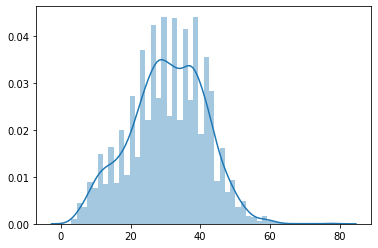

In [24]:
#sequence length of the train dataset
train_length_dist=[]

for l in train["Tokened_Text"]:
    train_length_dist+=[len(l)]
y = np.array(train_length_dist)
sns.distplot(y);

In [0]:
#Model need two types of data: input_ids (sequence), attention_masks)
input_ids_train = train_input[0]
attention_masks_train = train_input[1]
input_ids_test =test_input[0]
attention_masks_test = test_input[1]

In [26]:
print(input_ids_train)

[[    2   690 12134 ...     0     0     0]
 [    2   987   337 ...     0     0     0]
 [    2   319  4995 ...     0     0     0]
 ...
 [    2  5086    17 ...     0     0     0]
 [    2   537  3264 ...     0     0     0]
 [    2   143  1043 ...     0     0     0]]


In [0]:
#Build a cover on top of hugging face pretrained model. Here is another example https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2

In [0]:
class CustomModel(TFRobertaPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super(CustomModel, self).__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels
        self.roberta = TFRobertaMainLayer(config, name="roberta")
        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(units=config.num_labels,
                                                name='classifier', 
                                                kernel_initializer=get_initializer(
                                                    config.initializer_range))

    def call(self, inputs, **kwargs):
        outputs = self.roberta(inputs, **kwargs)
        pooled_output = outputs[1]
        pooled_output = self.dropout_1(pooled_output, training=kwargs.get('training', False))
        logits = self.classifier(pooled_output)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        return outputs

In [29]:
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(resolver)


# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
        
    config = RobertaConfig.from_pretrained('roberta-base')
    model = CustomModel.from_pretrained('roberta-base')
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124645632 
_________________________________________________________________
dropout_38 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


In [30]:
batch_size = 128
skf = StratifiedKFold(n_splits=5, shuffle=False)
X, y = input_ids_train, train['target'].values.reshape(-1, 1)
skf.get_n_splits(X, y)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, attention_masks_train_stratified, X_test, attention_masks_test_stratified = X[train_index], attention_masks_train[train_index], X[test_index], attention_masks_train[test_index]
    y_train, y_test = tf.keras.utils.to_categorical(y[train_index]), tf.keras.utils.to_categorical(y[test_index])
    X_train = X_train[:-divmod(X_train.shape[0], batch_size)[1]]
    attention_masks_train_stratified = attention_masks_train_stratified[:-divmod(attention_masks_train_stratified.shape[0], batch_size)[1]]
    y_train = y_train[:-divmod(y_train.shape[0], batch_size)[1]]
    model.fit([X_train, attention_masks_train_stratified], y_train, validation_data=([X_test, attention_masks_test_stratified], y_test), batch_size=batch_size, epochs=5)
    print('Split ' + str(i) + ' is finished.')

Train on 6016 samples, validate on 1523 samples
Epoch 1/5
6016/6016 [==============================] - 86s 14ms/sample - loss: 0.6580 - accuracy: 0.5230 - val_loss: 0.6750 - val_accuracy: 0.5794
Epoch 2/5
6016/6016 [==============================] - 8s 1ms/sample - loss: 0.6200 - accuracy: 0.5673 - val_loss: 0.6261 - val_accuracy: 0.5814
Epoch 3/5
6016/6016 [==============================] - 7s 1ms/sample - loss: 0.5641 - accuracy: 0.6198 - val_loss: 0.6184 - val_accuracy: 0.5532
Epoch 4/5
6016/6016 [==============================] - 8s 1ms/sample - loss: 0.4893 - accuracy: 0.6820 - val_loss: 0.6386 - val_accuracy: 0.6504
Epoch 5/5
6016/6016 [==============================] - 8s 1ms/sample - loss: 0.4124 - accuracy: 0.7657 - val_loss: 0.7497 - val_accuracy: 0.6737
Split 0 is finished.
Train on 6016 samples, validate on 1523 samples
Epoch 1/5
6016/6016 [==============================] - 29s 5ms/sample - loss: 0.4380 - accuracy: 0.7565 - val_loss: 0.2383 - val_accuracy: 0.8835
Epoch 2/5


In [31]:
#predict

model_output = model.predict([input_ids_test, attention_masks_test])
submission['target'] = np.argmax(model_output, axis=1).flatten()
submission['target'].value_counts()

0    1779
1    1484
Name: target, dtype: int64

In [32]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
